# EDA: Market Basket Analysis
- Ontology에 사전정의된 Slot(`meta_slot`)과 Dialogue 내 발화에 등장하는 단어 간 연관성을 분석
- Skill. 장바구니 분석(market basket analysis)

## Market Basket Analysis
- Association Rules라고 부르기도 함
- 다음의 3가지 지표를 활용
    1. 지지도(Support): (상품 A와 B가 동시에 포함된 사례 수) / (전체 사례 수), P(A∩B)
    2. 신뢰도(Confidence): (상품 A와 B가 동시에 포함된 사례 수) / (상품 A가 포함된 사례 수), P(A∩B) / P(A)
    3. 향상도(Lift): 상품 A가 없을 때 상품 B가 있을 확률과 상품 A가 있을 때 상품 B가 있을 확률의 비율, P(A∩B) / P(A)*P(B) = P (B|A) / P (B)
- 그렇다면, WoS 데이터셋에 어떻게 적용할 것인지 구체적으로 작성해보자.

### Market Basket Analysis for WoS
- level
    - '어떤 사람이 쇼핑을 하면서 구매한 상품 목록'은 구매 사례를 파악하는 단위가 '개인'임
    - 같은 맥락으로, WoS 데이터셋에는 어떤 단위가 좋을까?
    - 데이터를 살펴보니, turn 단위로 키워드 등장 빈도를 count하기에는, 추출되는 단어가 너무 적음
    - task-oriented dialogue는 기본적으로 하나의 대화가 하나의 주제를 가진다는 점에서, 빈도 count의 단위를 dialogue로 보는 것이 좋을 듯!

## WoS
- \# Meta Domain: Travel
- \# Domain: 5
- \# Slot: 45
- \# Avg Turn: 14.67
- \# Tokens per turn


In [25]:
import json
import sys
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import konlpy
from konlpy.tag import Okt # Mecab은 윈도우 미지원
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
pd.set_option('display.max_rows', 500)
plt.style.use('ggplot')
plt.rc('font', family='AppleSDGothicNeoSB00')
sys.path.insert(0, '../')

from utils import load_json

#### Load Data

In [12]:
SLOTMETA = '../input/data/train_dataset/slot_meta.json'
ONTOLOGY = '../input/data/train_dataset/ontology.json'
DIALS = '../input/data/train_dataset/train_dials.json'

In [13]:
ontology = load_json(ONTOLOGY)
slot_meta = load_json(SLOTMETA)
dials = load_json(DIALS)

#### Preprocessing for Market Basket Analysis

In [14]:
tagger = Okt()

In [15]:
NOUN = 'Noun'

def get_slot_meta(x):
    return '-'.join(x.split('-')[:-1])

def get_keywords(x, tagger: konlpy.tag):
    text_parsed = tagger.pos(x)
    parsed_filtered = filter(lambda x: x[-1] == NOUN and len(x[0]) > 1, text_parsed) # 명사 & 길이 2 이상
    keywords = list(map(lambda x: x[0], parsed_filtered))
    return keywords

total_items = [] # dialogue 단위로 단어 수집

for dial in tqdm(dials):
    dial_items = set()
    for turn in dial['dialogue']:
        if turn['role'] == 'sys':
            continue
        slot_items = set(map(get_slot_meta, turn['state']))
        keywords_items = set(get_keywords(turn['text'], tagger))
        turn_items = slot_items.union(keywords_items)
        dial_items = dial_items.union(turn_items)
    
    total_items.append(list(dial_items))

100%|██████████████████████████████████████████████████████████████████████████████| 7000/7000 [01:24<00:00, 82.86it/s]


- 각 dialogue 별 수집 frequency 파악

In [18]:
frequency = pd.Series(list(map(len, total_items)))

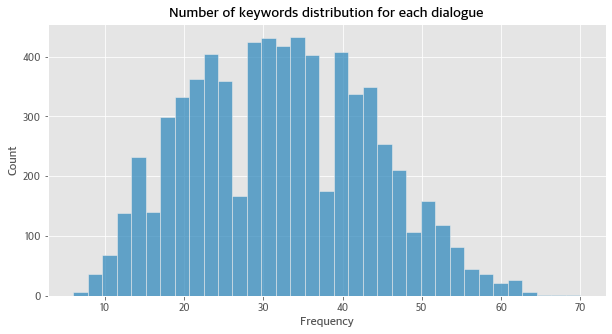

In [22]:
plt.figure(figsize=(10, 5))
sns.histplot(frequency)
plt.title('Number of keywords distribution for each dialogue')
plt.xlabel('Frequency')
plt.show()

In [45]:
frequency.describe()

count    7000.000000
mean       32.204286
std        11.460935
min         6.000000
25%        23.000000
50%        32.000000
75%        41.000000
max        70.000000
dtype: float64

- 쓸데 없는 단어 제거(stopword)

In [33]:
def flatten(x):
    output = []
    for value in x:
        if isinstance(x, list):
            output.extend(value)
        else:
            output.append(value)
    return output

In [34]:
total_items_flattend = flatten(total_items)

음 근데 생각보다 괜찮게 추출됐네. 이대로 가자

In [42]:
enc = TransactionEncoder()
transactions = enc.fit(total_items).transform(total_items, sparse=True)
transaction_table = pd.DataFrame.sparse.from_spmatrix(transactions, columns=enc.columns_)

In [43]:
transaction_table

,가가,가게,가격,가구,가기,가까이,가끔,가나,가능,가능성,...,후보,후움,휴가,휴식,휴일,흡연,흥미,흥인지문,힐링,힙니
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
apriori_table = apriori(transaction_table, min_support=0.2, use_colnames=True, verbose=1, low_memory=False)

Processing 984720 combinations | Sampling itemset size 8

In [47]:
apriori_table

,support,itemsets
0,0.606000,(가격)
1,0.510714,(관광-이름)
2,0.768429,(서울)
3,0.524714,(숙소-예약 기간)
4,0.524857,(숙소-예약 명수)
5,0.524714,(숙소-예약 요일)
6,0.540857,(숙소-이름)
7,0.546714,(식당-예약 명수)
8,0.547000,(식당-예약 시간)
9,0.547143,(식당-예약 요일)
